## 1. Plotting Actions vs Outcomes, cumulative reward and delta-p
----------------------------------------------------------------------------

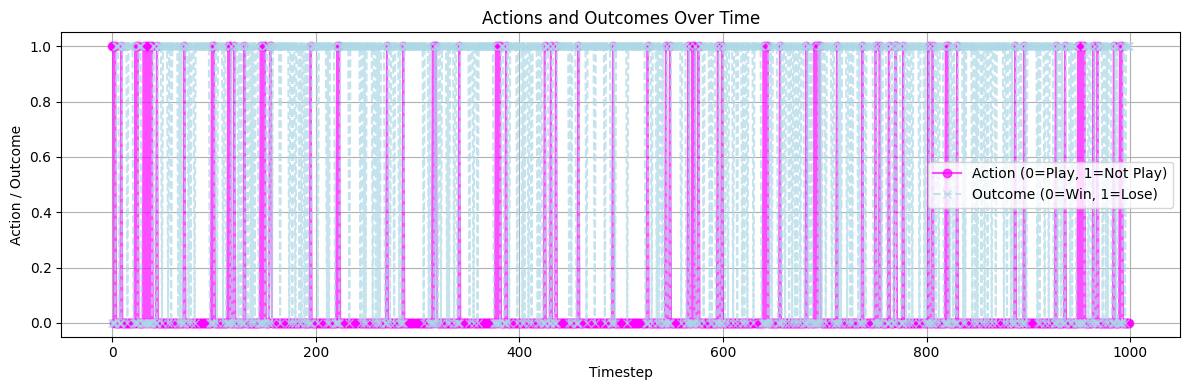

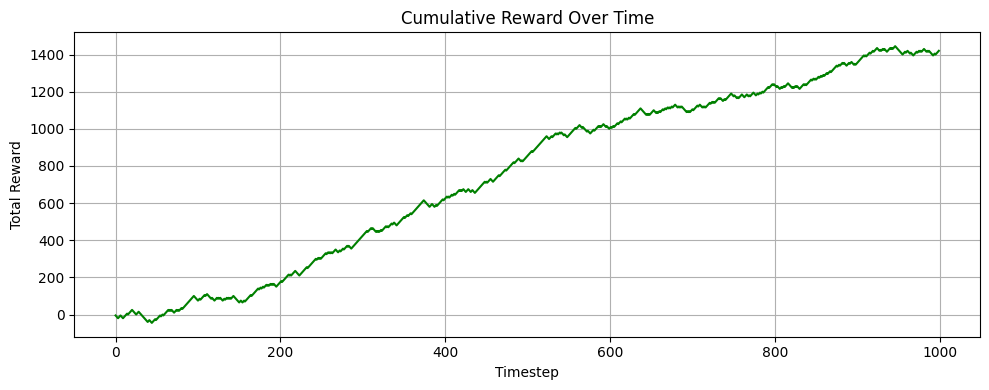

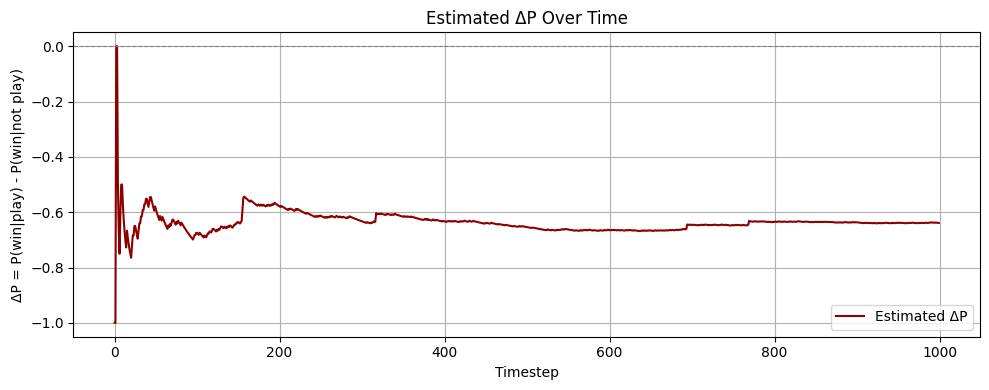

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pymdp.agent import Agent
from pymdp import utils
from pymdp.control import construct_policies

# --- Generative Model Parameters ---
A_matrix = np.array([
    [1.0, 0.0, 0.0],
    [0.0, 0.5, 0.0],
    [0.0, 0.5, 0.0],
    [0.0, 0.0, 0.5],
    [0.0, 0.0, 0.5]
])
A_matrix = A_matrix / A_matrix.sum(axis=0, keepdims=True)
A = np.empty((1,), dtype=object)
A[0] = A_matrix
pA = utils.dirichlet_like(A, scale=0.5)

B = np.zeros((3, 3, 2))
B[:, :, 0] = np.array([
    [0, 1, 1],
    [1, 0, 0],
    [0, 0, 0]
])
B[:, :, 1] = np.array([
    [0, 1, 1],
    [0, 0, 0],
    [1, 0, 0]
])
B += 0.05
B = B / B.sum(axis=0, keepdims=True)

C = np.array([-5 if i in [0,2,4] else 5 for i in range(5)]).reshape(-1, 1)
D = np.array([1, 0, 0])

# --- Simulation Function ---
def run_fixed_simulation(T=1000, p_win_given_play=0.3, p_win_given_noplay=0.9):
    agent = Agent(A=A, pA=pA, B=B, C=C, D=D)
    agent.gamma = 20
    agent.alpha = 1
    agent.use_states_info_gain = False
    agent.use_param_info_gain = False
    agent.policies = construct_policies([2], policy_len=2)
    agent.E = np.ones(len(agent.policies)) / len(agent.policies)

    obs = [1]
    actions, outcomes, rewards, dp_trace = [], [], [], []
    cumulative_reward = 0
    n_play = n_noplay = win_play = win_noplay = 0

    for t in range(T):
        agent.infer_states(obs)
        q_pi, efe = agent.infer_policies()
        action = int(agent.sample_action()[0])
        agent.update_A(obs)

        if action == 0:
            outcome = 0 if np.random.rand() < p_win_given_play else 1
            n_play += 1
            win_play += (outcome == 0)
        else:
            outcome = 0 if np.random.rand() < p_win_given_noplay else 1
            n_noplay += 1
            win_noplay += (outcome == 0)

        obs = [outcome]
        p_play = win_play / n_play if n_play > 0 else 0.0
        p_noplay = win_noplay / n_noplay if n_noplay > 0 else 0.0
        dp_trace.append(p_play - p_noplay)

        actions.append(action)
        outcomes.append(outcome)
        cumulative_reward += C[outcome, 0]
        rewards.append(cumulative_reward)

    return actions, outcomes, rewards, dp_trace

# --- Run and Plot Simulation ---
T = 1000
actions, outcomes, rewards, dp_trace = run_fixed_simulation(T)

# Plot Actions vs Outcomes
plt.figure(figsize=(12, 4))
plt.plot(actions, label="Action (0=Play, 1=Not Play)", marker='o', color='magenta', alpha=0.7)
plt.plot(outcomes, label="Outcome (0=Win, 1=Lose)", linestyle='--', marker='x', color='lightblue', alpha=0.7)
plt.title("Actions and Outcomes Over Time")
plt.xlabel("Timestep")
plt.ylabel("Action / Outcome")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Cumulative Reward
plt.figure(figsize=(10, 4))
plt.plot(rewards, label="Cumulative Reward", color='green')
plt.title("Cumulative Reward Over Time")
plt.xlabel("Timestep")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot ΔP trace
plt.figure(figsize=(10, 4))
plt.plot(dp_trace, label="Estimated ΔP", color='darkred')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title("Estimated ΔP Over Time")
plt.xlabel("Timestep")
plt.ylabel("ΔP = P(win|play) - P(win|not play)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## 2. Plotting the delta-p over 15 scenarios - model evaluation
--------------------------------------------------------------------------

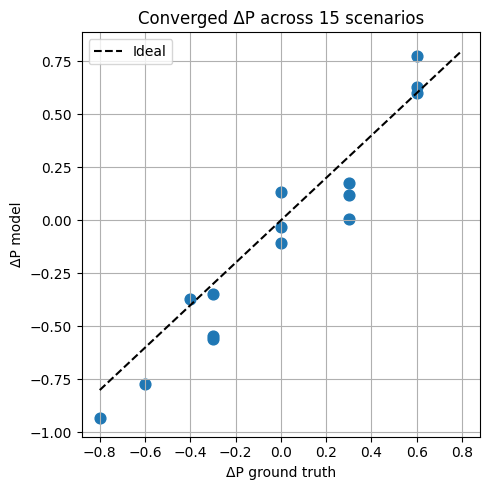

In [7]:
# === Imports ===
import numpy as np
import matplotlib.pyplot as plt

# PyMDP: Active Inference components
from pymdp.agent import Agent                   # The active inference agent
from pymdp import utils                        # Utility functions for Dirichlet, etc.
from pymdp.control import construct_policies   # To build policies of actions

# === 1. GENERATIVE MODEL SETUP ===

# Observation model A: 5 states x 3 outcomes
# State 0 always gives obs 0 (win); State 1/2 gives 50% obs 1; State 3/4 gives 50% obs 2
A_matrix = np.array([
    [1.0, 0.0, 0.0],  # State 0 → always win
    [0.0, 0.5, 0.0],  # State 1 → 50% chance obs 1
    [0.0, 0.5, 0.0],  # State 2 → 50% chance obs 1
    [0.0, 0.0, 0.5],  # State 3 → 50% chance obs 2
    [0.0, 0.0, 0.5]   # State 4 → 50% chance obs 2
])
A_matrix = A_matrix / A_matrix.sum(axis=0, keepdims=True)  # Normalize columns

A = np.empty((1,), dtype=object)
A[0] = A_matrix

# Prior counts for learning the A matrix (used in parameter inference)
pA = utils.dirichlet_like(A, scale=0.5)

# Transition model B: 3 states → transition rules for actions 0 and 1
B = np.zeros((3, 3, 2))
B[:, :, 0] = np.array([[0, 1, 1], [1, 0, 0], [0, 0, 0]])  # Action 0: PLAY
B[:, :, 1] = np.array([[0, 1, 1], [0, 0, 0], [1, 0, 0]])  # Action 1: NOT PLAY
B += 0.05  # Add small noise to avoid zeros
B = B / B.sum(axis=0, keepdims=True)  # Normalize transitions

# Reward model C: observation-based preference
# Rewards for outcomes 0, 2, 4 (wins) = +5; others = -10
C = np.array([5 if i in [0, 2, 4] else -10 for i in range(5)]).reshape(-1, 1)

# Prior belief over initial state
D = np.array([1, 0, 0])  # Always start in state 0

# === 2. SIMULATION FUNCTION TO ESTIMATE ΔP ===

def run_dp_estimation(T, p_win_play, p_win_noplay):
    """
    Simulate T steps with an Active Inference agent and estimate
    ΔP = P(win|play) - P(win|not play) from observed data.
    """
    # Instantiate agent with given generative model
    agent = Agent(A=A, pA=pA, B=B, C=C, D=D)
    agent.gamma = 50.0  # Precision over policies (softmax sharpness)
    agent.alpha = 0.015   # Learning rate for A matrix
    agent.use_states_info_gain = False  # Explore hidden states
    agent.use_param_info_gain = True   # Explore A matrix (structure)
    agent.policies = construct_policies([2], policy_len=2)  # 2 actions, depth-2 policies
    agent.E = np.ones(len(agent.policies)) / len(agent.policies)  # Uniform prior over policies

    obs = [1]  # Start with a "lose" outcome
    n_play = n_noplay = win_play = win_noplay = 0  # Counters for ΔP estimation

    for _ in range(T):
        # Perception and planning
        agent.infer_states(obs)                    # Update belief about state
        q_pi, efe = agent.infer_policies()         # Update belief over policies
        action = int(agent.sample_action()[0])     # Sample action from posterior over policies
        agent.update_A(obs)                        # Update A matrix (parameter learning)

        # Generate outcome based on synthetic ground-truth probabilities
        if action == 0:  # PLAY
            outcome = 0 if np.random.rand() < p_win_play else 1
            n_play += 1
            win_play += (outcome == 0)
        else:  # NOT PLAY
            outcome = 0 if np.random.rand() < p_win_noplay else 1
            n_noplay += 1
            win_noplay += (outcome == 0)

        obs = [outcome]  # Feed outcome back into agent

    # Empirical estimation of ΔP from observed actions and outcomes
    p_play = win_play / n_play if n_play > 0 else 0.0
    p_noplay = win_noplay / n_noplay if n_noplay > 0 else 0.0
    return p_play - p_noplay  # This is the model's estimate of ΔP

# === 3. DEFINE SCENARIOS AND RUN SIMULATIONS ===

# List of 15 ground-truth (P(win|play), P(win|not play)) pairs
scenarios = [
    (0.9, 0.3), (0.8, 0.2), (0.7, 0.1), (0.7, 0.4), (0.6, 0.3),
    (0.5, 0.2), (0.6, 0.6), (0.4, 0.4), (0.5, 0.5), (0.3, 0.7),
    (0.2, 0.8), (0.1, 0.9), (0.2, 0.5), (0.3, 0.6), (0.4, 0.7)
]

T = 50  # Number of trials per simulation
dp_true = []   # Ground-truth ΔP values
dp_model = []  # Model-estimated ΔP values

# Loop over scenarios and run estimation
for p1, p0 in scenarios:
    dp_true.append(p1 - p0)                     # True ΔP
    dp_model.append(run_dp_estimation(T, p1, p0))  # Model estimate

# === 4. PLOT RESULTS ===

plt.figure(figsize=(5, 5))
plt.scatter(dp_true, dp_model, s=60)  # Each point is one simulation
plt.plot([-0.8, 0.8], [-0.8, 0.8], 'k--', label="Ideal")  # y = x line
plt.xlabel("ΔP ground truth")
plt.ylabel("ΔP model")
plt.title("Converged ΔP across 15 scenarios")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 3. Plotting the learning curve - Accuracy across scenarios
-------------------------------------------

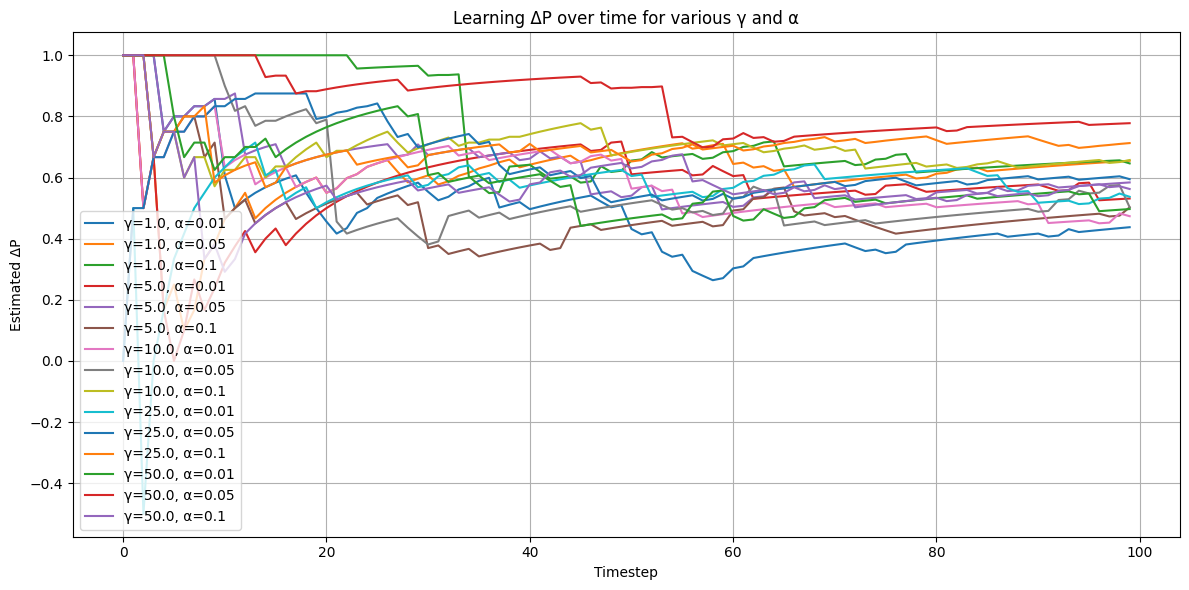

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pymdp.agent import Agent
from pymdp import utils
from pymdp.control import construct_policies

# === Generative Model Setup ===

# A_matrix: Observation likelihood — shape (5 outcomes × 3 hidden states)
# Each column represents the distribution over observations for a hidden state
A_matrix = np.array([
    [1.0, 0.0, 0.0],  # State 0 → always observe outcome 0 (win)
    [0.0, 0.5, 0.0],  # State 1 → 50% chance of outcome 1 (lose)
    [0.0, 0.5, 0.0],  # State 1 → 50% chance of outcome 2
    [0.0, 0.0, 0.5],  # State 2 → 50% chance of outcome 3
    [0.0, 0.0, 0.5]   # State 2 → 50% chance of outcome 4
])
A_matrix = A_matrix / A_matrix.sum(axis=0, keepdims=True)  # Normalize columns
A = np.empty((1,), dtype=object)  # Wrap as required by PyMDP
A[0] = A_matrix

# Prior concentration parameters (Dirichlet priors) for parameter learning
pA = utils.dirichlet_like(A, scale=0.5)

# B_matrix: Transition model — shape (next_state, current_state, action)
# Defines how states evolve under each action
B = np.zeros((3, 3, 2))
B[:, :, 0] = np.array([[0, 1, 1], [1, 0, 0], [0, 0, 0]])  # Action 0: PLAY
B[:, :, 1] = np.array([[0, 1, 1], [0, 0, 0], [1, 0, 0]])  # Action 1: NOT PLAY
B += 0.05  # Add noise to avoid zeros
B = B / B.sum(axis=0, keepdims=True)  # Normalize transitions

# C vector: Encodes preference over outcomes (C[o] = utility)
# Rewards: outcome 0, 2, 4 → +5; all others → -10
C = np.array([5 if i in [0, 2, 4] else -10 for i in range(5)]).reshape(-1, 1)

# D vector: Prior over initial hidden states
D = np.array([1, 0, 0])  # Always start in state 0

# === Simulation Function: Estimate ΔP Over Time ===

def run_learning_curve(T, gamma, alpha, p_win_play=0.8, p_win_noplay=0.2):
    agent = Agent(A=A, pA=utils.dirichlet_like(A, scale=0.5), B=B, C=C, D=D)
    agent.gamma = gamma
    agent.alpha = alpha
    agent.use_states_info_gain = False
    agent.use_param_info_gain = True
    agent.policies = construct_policies([2], policy_len=2)
    agent.E = np.ones(len(agent.policies)) / len(agent.policies)

    obs = [1]
    n_play = n_noplay = win_play = win_noplay = 0
    dp_trace = []
    qx_trace = []     # inferred hidden state beliefs
    qpi_trace = []    # policy posterior (probability of choosing each policy)

    for _ in range(T):
        agent.infer_states(obs)
        q_pi, efe = agent.infer_policies()
        action = int(agent.sample_action()[0])
        agent.update_A(obs)

        # Log current beliefs
        qx_trace.append(agent.qs[0].copy())      # inferred hidden state probabilities
        qpi_trace.append(q_pi.copy())            # policy posteriors

        # Simulated environment response
        if action == 0:
            outcome = 0 if np.random.rand() < p_win_play else 1
            n_play += 1
            win_play += (outcome == 0)
        else:
            outcome = 0 if np.random.rand() < p_win_noplay else 1
            n_noplay += 1
            win_noplay += (outcome == 0)

        obs = [outcome]

        # ΔP update
        p_play = win_play / n_play if n_play > 0 else 0.0
        p_noplay = win_noplay / n_noplay if n_noplay > 0 else 0.0
        dp_trace.append(p_play - p_noplay)

    return dp_trace, qx_trace, qpi_trace

# === Run Learning Curves for Multiple Gamma/Alpha Combinations ===

gammas = [1.0, 5.0, 10.0, 25.0, 50.0]  # Precision over policies
alphas = [0.01, 0.05, 0.1]             # Learning rates
T = 100                                # Number of time steps
results = {}                           # Store curves for each configuration

# Run simulations
for gamma in gammas:
    for alpha in alphas:
        label = f"γ={gamma}, α={alpha}"  # Legend label
        dp_curve, qx_trace, qpi_trace = run_learning_curve(T, gamma, alpha)
        results[label] = dp_curve  # Only store ΔP for plotting
        # You can also store qx_trace/qpi_trace in separate dicts if needed


# === Plotting ===

plt.figure(figsize=(12, 6))
for label, curve in results.items():
    plt.plot(curve, label=label)  # Plot one curve per config
plt.title("Learning ΔP over time for various γ and α")
plt.xlabel("Timestep")
plt.ylabel("Estimated ΔP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 4. Plotting the learning curve - Learning dynamics across hyperparameters
--------------------------------------------------------------------------------

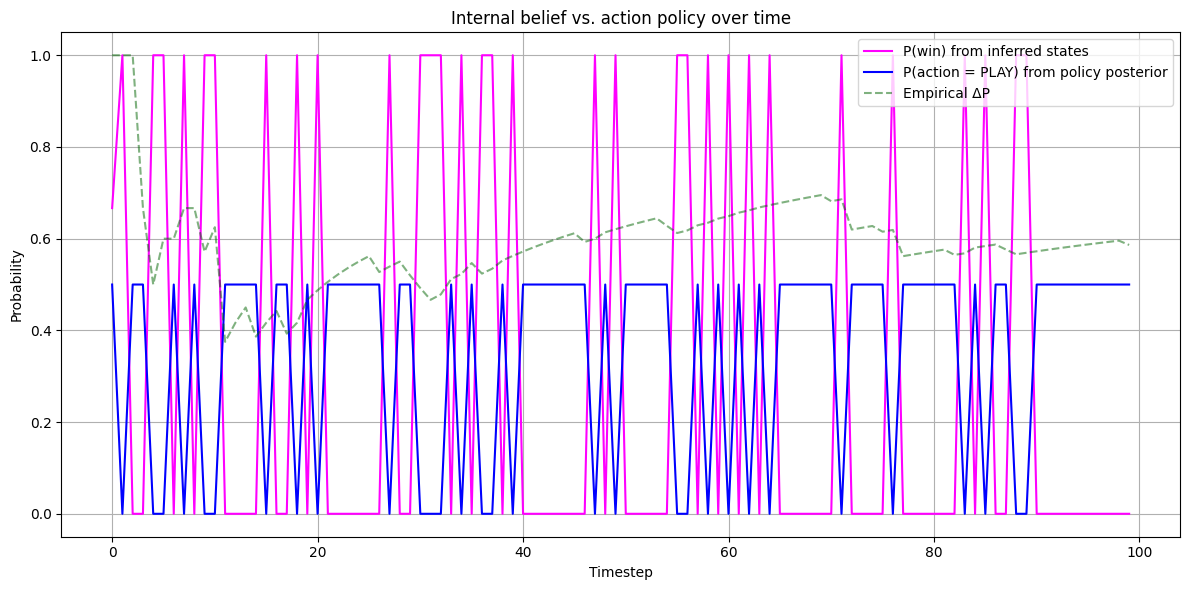

In [9]:
# === Imports ===
import numpy as np
import matplotlib.pyplot as plt
from pymdp.agent import Agent
from pymdp import utils
from pymdp.control import construct_policies

# === Generative Model Setup ===

# Define observation likelihood matrix A: shape (5 outcomes × 3 hidden states)
# Each column represents what outcomes the agent expects to observe in a given state
A_matrix = np.array([
    [1.0, 0.0, 0.0],  # State 0 always produces outcome 0 (win)
    [0.0, 0.5, 0.0],  # State 1 produces outcome 1 with 50% probability
    [0.0, 0.5, 0.0],  # State 1 also produces outcome 2 with 50%
    [0.0, 0.0, 0.5],  # State 2 produces outcome 3 with 50%
    [0.0, 0.0, 0.5]   # State 2 also produces outcome 4 with 50%
])
A_matrix = A_matrix / A_matrix.sum(axis=0, keepdims=True)  # Normalize per column
A = np.empty((1,), dtype=object)
A[0] = A_matrix

# Create prior Dirichlet parameters over A for parameter learning
pA = utils.dirichlet_like(A, scale=0.5)

# Define transition model B: shape (3 next states × 3 current states × 2 actions)
# B[:, :, 0] is the transition model for action PLAY, B[:, :, 1] for NOT PLAY
B = np.zeros((3, 3, 2))
B[:, :, 0] = np.array([[0, 1, 1], [1, 0, 0], [0, 0, 0]])  # PLAY transitions
B[:, :, 1] = np.array([[0, 1, 1], [0, 0, 0], [1, 0, 0]])  # NOT PLAY transitions
B += 0.05  # Add noise to avoid deterministic zeros
B = B / B.sum(axis=0, keepdims=True)  # Normalize transitions

# Define preference vector C over observations (rewards): +5 for win-like outcomes, -10 for others
C = np.array([5 if i in [0, 2, 4] else -10 for i in range(5)]).reshape(-1, 1)

# Initial belief over hidden states: start always in state 0
D = np.array([1, 0, 0])

# === Simulation Function ===

def run_learning_curve(T, gamma=50.0, alpha=0.015, p_win_play=0.8, p_win_noplay=0.2):
    """
    Simulates an agent interacting with the environment for T steps.
    Tracks belief updates and action tendencies.
    """
    agent = Agent(A=A, pA=utils.dirichlet_like(A, scale=0.5), B=B, C=C, D=D)
    agent.gamma = gamma                         # Precision of policy selection (higher = more deterministic)
    agent.alpha = alpha                         # Learning rate for A matrix updates
    agent.use_states_info_gain = False          # No intrinsic drive to explore hidden states
    agent.use_param_info_gain = True            # Enable learning of observation model (A matrix)
    agent.policies = construct_policies([2], policy_len=2)  # Generate 2-step policies for 2 actions
    agent.E = np.ones(len(agent.policies)) / len(agent.policies)  # Uniform prior over policies

    # Initial observation: outcome 1 (loss)
    obs = [1]
    n_play = n_noplay = win_play = win_noplay = 0  # Counters for estimating empirical ΔP

    # Traces to collect over time
    qx_trace = []               # Inferred beliefs over hidden states
    qpi_trace = []              # Policy posterior
    dp_trace = []               # Empirical ΔP trace
    p_win_trace = []            # Agent’s belief in "win" from current state beliefs
    p_action_play_trace = []    # Total probability of choosing PLAY

    for _ in range(T):
        # Perception and planning
        agent.infer_states(obs)                   # Update hidden state beliefs (qs)
        q_pi, efe = agent.infer_policies()        # Compute policy posterior and expected free energy
        action = int(agent.sample_action()[0])    # Sample action from policy posterior
        agent.update_A(obs)                       # Update A matrix (observation model)

        # Save beliefs
        qx = agent.qs[0].copy()
        qx_trace.append(qx)
        qpi_trace.append(q_pi.copy())

        # Compute inferred probability of win (outcome 0), given current state belief
        inferred_p_win = A[0][0, :] @ qx
        p_win_trace.append(inferred_p_win)

        # Compute P(action = PLAY) from policy posterior
        policy_is_play = [p[0] == 0 for p in agent.policies]  # Identify policies starting with PLAY
        p_play = np.sum([q_pi[i] for i, is_play in enumerate(policy_is_play) if is_play])
        p_action_play_trace.append(p_play)

        # Simulate environment outcome from true ground-truth win probabilities
        if action == 0:
            outcome = 0 if np.random.rand() < p_win_play else 1
            n_play += 1
            win_play += (outcome == 0)
        else:
            outcome = 0 if np.random.rand() < p_win_noplay else 1
            n_noplay += 1
            win_noplay += (outcome == 0)

        # Update observation
        obs = [outcome]

        # Empirical ΔP estimate: difference in win rate between PLAY and NOT PLAY
        p_emp_play = win_play / n_play if n_play > 0 else 0.0
        p_emp_noplay = win_noplay / n_noplay if n_noplay > 0 else 0.0
        dp_trace.append(p_emp_play - p_emp_noplay)

    return {
        "dp_trace": dp_trace,
        "qx_trace": qx_trace,
        "qpi_trace": qpi_trace,
        "p_win_trace": p_win_trace,
        "p_action_play_trace": p_action_play_trace
    }

# === Run the Simulation ===

T = 100
results = run_learning_curve(T)

# === Plot Results ===

plt.figure(figsize=(12, 6))

# Plot inferred belief in winning outcome
plt.plot(results["p_win_trace"], label="P(win) from inferred states", color="magenta")

# Plot posterior probability of choosing PLAY
plt.plot(results["p_action_play_trace"], label="P(action = PLAY) from policy posterior", color="blue")

# Optional: plot empirical ΔP from observations
plt.plot(results["dp_trace"], label="Empirical ΔP", linestyle="--", alpha=0.5,color="darkgreen")

plt.title("Internal belief vs. action policy over time")
plt.xlabel("Timestep")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
